Summa kostnad i el 2023: 34431902.704115376
Justerad elkostnad simulering: 27096242.099432904


C:\Users\jakob\AppData\Local\Temp\ipykernel_5808\3785277770.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")


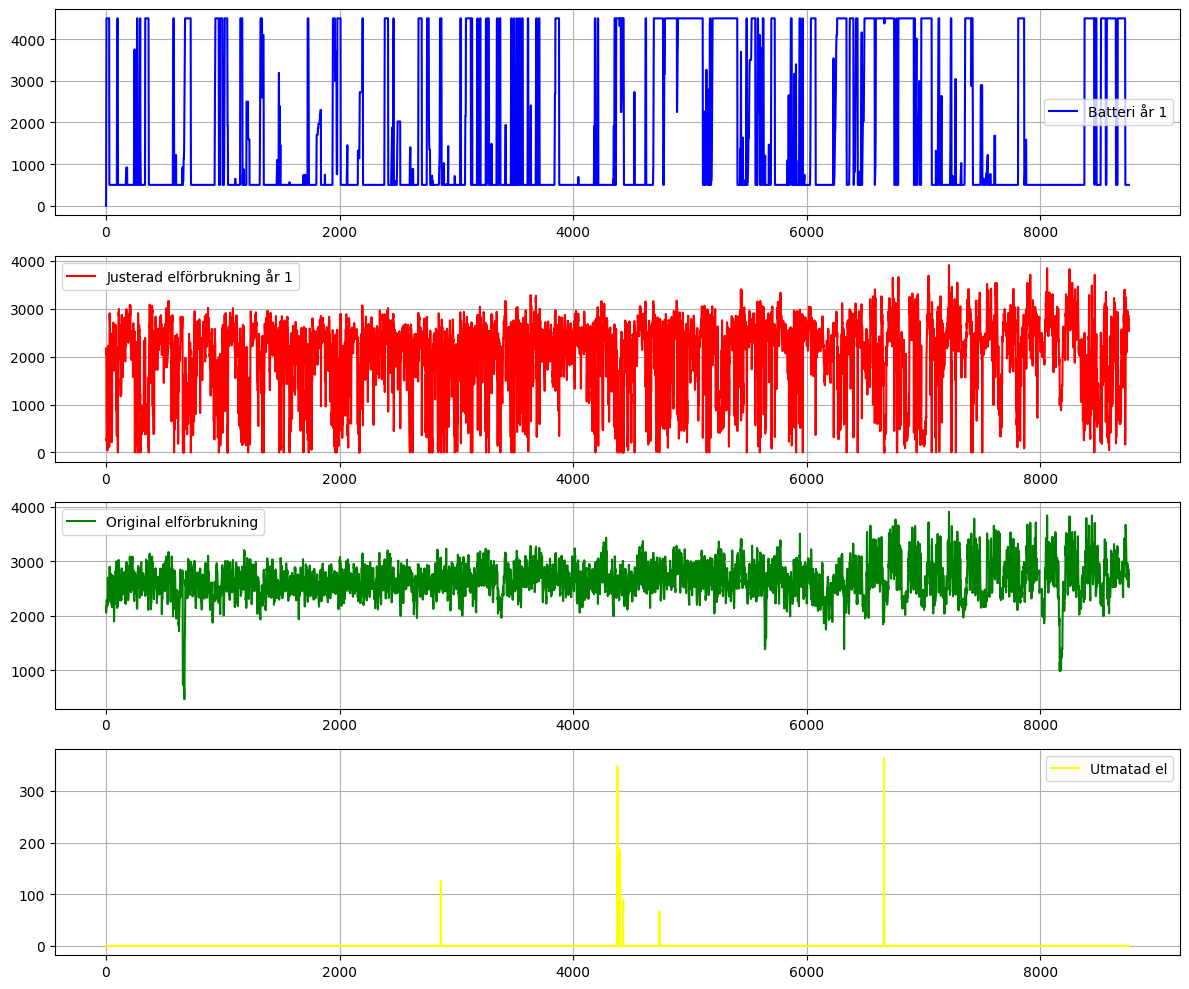

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
Solprod = pd.read_excel("Soldata-filerSÖDRA/SummaSödraSolPROD.xlsx")
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"])  # Namnge kolumnen korrekt
Vindprod = pd.read_excel("Vindturbin.xlsx")
SödraOmr = pd.read_excel("Eldata-filerSÖDRA/SummaSödraOmrådet.xlsx")

# Extrahera första kolumnen från respektive DataFrame
Vind = Vindprod.iloc[:, 0]
Sol = 0.4*Solprod.iloc[:, 0]  # Solel-produktion multipliceras med faktor 0.7 eftersom hela takytan inte används
Spot = Spotpris.iloc[:, 0]
SöOmr = SödraOmr.iloc[:,0]

Prod =   Vind + Sol


elhandelskostnad = (Spot * SöOmr).sum() / 100
energiskatt = (43.9 * SöOmr).sum() / 100

summaElKostnad = (elhandelskostnad + energiskatt) * 1.25
print("Summa kostnad i el 2023:", summaElKostnad)

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)
# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
min_battery_level = batteriMaxKapacitet*0.1
max_battery_level = batteriMaxKapacitet * 0.9
maxFrånBatteri = max_battery_level*0.5
original_consumption = SöOmr.tolist()
elförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
utmatning = []
köptaTimmar = []

for tid, prod, söomr, spot in zip(Spotpris.index, Prod, SöOmr, Spot):  
    diff = söomr - prod  # Skillnad mellan förbrukning och solproduktion

    if diff <= 0:
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        batteriKapacitet = min(batteriKapacitet - diff, max_battery_level)  # -diff eftersom diff är negativ
        elförbrukning.append(0)  # Vi behöver inte köpa el
        utmatning.append(max(0,batteriKapacitet - diff - max_battery_level))
        köptaTimmar.append((tid,0))
    else:
        if spot <= 35 and prod > 0:
            if batteriKapacitet + prod >= max_battery_level: 
                prodÖver = (batteriKapacitet + prod) - max_battery_level
                batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                köpt_el = max(0, söomr-prodÖver)
                elförbrukning.append(köpt_el)  
                köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
                utmatning.append(0)
            else:
                batteriKapacitet = min(batteriKapacitet + prod, max_battery_level)
                elförbrukning.append(söomr)
                köptaTimmar.append((tid, spot))
                utmatning.append(0)  
        elif 35 < spot < 65.75 and prod > 0:
            elförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)
        elif spot >= 65.75:
            energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri, batteriKapacitet-min_battery_level)
            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            elförbrukning.append(köpt_el)
            utmatning.append(0)
        else:
            elförbrukning.append(söomr)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)


    battery_values.append(batteriKapacitet)


köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": elförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(elförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (JusteradEnergiskatt + elhandelskostnad_köpt)
print("Justerad elkostnad simulering:", summaJusteradElkostnad)


# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(elförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')
ax[3].plot(utmatning, label='Utmatad el', color='yellow')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()